In [1]:
%config IPCompleter.greedy=True
%matplotlib inline

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import numpy as np
from IPython.display import HTML
from IPython.display import display, clear_output

In [3]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

In [4]:
device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda')
device

device(type='cuda')

In [5]:
class SPH(nn.Module):
    def __init__(self, particle_num, particle_size, viscosity, kernel, kernel_grad, v_kernel_grad, boundary_num, boundary_pos, mass, step_time):
        super(SPH, self).__init__()
        self.particle_num = particle_num
        self.particle_size = particle_size
        self.viscosity = viscosity
        self.kernel = kernel
        self.kernel_grad = kernel_grad
        self.v_kernel_grad = v_kernel_grad
        self.boundary_num = boundary_num
        self.boundary_pos = boundary_pos
        self.mass = mass
        self.step_time = step_time
        self.total_num = self.particle_num + self.boundary_num

    def forward(self, pos, vel, f_ext):
        cat_pos = torch.cat((pos, self.boundary_pos),0)
        cat_vel = torch.cat((vel, torch.zeros((self.boundary_num, 2), device = device)),0)
        rest_density = self.mass[0] * self.kernel(torch.tensor([0.], device = device))

        diff = cat_pos.view(self.particle_num, 1, 2) - cat_pos.view(1, self.total_num, 2)
        r = torch.norm(diff, dim=2)
        w = self.kernel(r)
        density = torch.sum(self.mass.view(1, self.total_num) * w, 1)
        
        vel_diff = cat_vel.view(self.total_num, 1, 2) - cat_vel.view(1, self.total_num , 2)
        grad_w = diff / r.view(self.total_num, self.total_num, 1) * self.kernel_grad(r).view(self.total_num, self.total_num, 1)
        grad_w[torch.isnan(grad_w)] = 0
        
        grad_vw = diff / r.view(self.total_num, self.total_num, 1) * self.v_kernel_grad(r).view(self.total_num, self.total_num, 1)
        grad_vw[torch.isnan(grad_vw)] = 0
        
        grad2_vel_1p = -vel_diff * self.mass.view(1, self.total_num, 1) / density.view(1, self.total_num, 1)
        grad2_vel_2p = 2 * grad_vw / r.view(self.total_num, self.total_num, 1)
        grad2_vel_2p[torch.isnan(grad2_vel_2p)] = 0
        grad2_vel = torch.sum(grad2_vel_1p * grad2_vel_2p, 1)
        

        f_viscosity = self.mass[:self.particle_num] * self.viscosity * grad2_vel[:self.particle_num]
        mid_vel = vel + self.step_time / self.mass[:self.particle_num] * (f_viscosity + f_ext)
        
        
        
        pressure = 10 * ((density / rest_density) ** 7 - 1)
        f_pressure_1p = pressure / (density ** 2)
        f_pressure_2p = f_pressure_1p.view(self.total_num, 1, 1) + f_pressure_1p.view(1, self.total_num, 1)
        f_pressure_3p = f_pressure_2p * self.mass.view(1, self.total_num, 1) * grad_w
        
        f_pressure = density.view(self.total_num, 1) * torch.sum(f_pressure_3p, 1)
        
        new_vel = mid_vel + self.step_time / self.mass[:self.particle_num] * (0 * f_pressure[:self.particle_num])
        new_pos = torch.clamp(pos + self.step_time * new_vel, 0, 1)
        
        return new_pos, new_vel

In [6]:
def kernel1(r, h = 0.025):
    q = r / h
    l1 = q <= 0.5
    l2 = q <= 1
    
    return 40 / 7 / math.pi / (h ** 2) * (l1 * (6 * (q**3 - q**2) + 1) + ~l1 * l2 * (2 * ((1 - q) ** 3)))

In [7]:
def kernel1_grad(r, h = 0.025):
    q = r / h
    l1 = torch.logical_and(0 <= q, q <= 0.5)
    l2 = torch.logical_and(0.5 < q, q <= 1)
    
    return 40 / 7 / math.pi / (h ** 2) * (l1 * (6 * (3 * q**2 - 2 *q)) + torch.logical_not(l1) * l2 * (-6 * ((1 - q)**2)))/ h

In [8]:
def kernel2_grad(r, h = 0.025):
    q = r / h
    l1 = q <= 1
    
    return 10 / 3 / math.pi / (h ** 4) * (l1 * (-3./2.*q + 2 - 1. / 2. / (q**3)) * r)

In [9]:
def visualize(pos):
    plt.figure(figsize=(5, 5))
    plt.scatter(pos[:, 0].tolist(), pos[:, 1].tolist())
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.show()

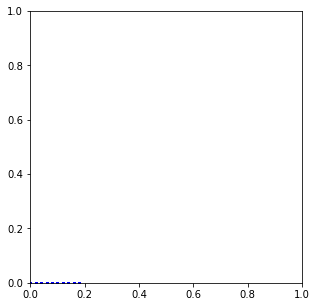

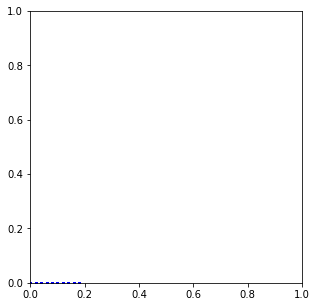

In [10]:
def main():
    kernel_size = 0.025
    particle_num = 100
    boundary_gap = kernel_size * 0.5
    boundary_layer = 3
    boundary_num = 0
    for i in range(boundary_layer):
        
    step_num = 1000
    particle_pos = torch.zeros((particle_num, 2), dtype=torch.float64, device=device, requires_grad = True)
    particle_mass = torch.ones((particle_num, 1), dtype=torch.float64, device=device, requires_grad = True)
    particle_pos = torch.zeros((particle_num, 2), dtype=torch.float64, device=device, requires_grad = True)
    boundary_pos = torch.zeros((boundary_num, 2), dtype=torch.float64, device=device, requires_grad = True)
    particle_vel = torch.zeros((particle_num, 2), dtype=torch.float64, device=device, requires_grad = True)
    f_ext = torch.zeros((particle_num, 2), dtype=torch.float64, device=device, requires_grad = False)
    f_ext += torch.tensor([[0, -9.8]], dtype=torch.float64, device=device, requires_grad = False)
    
    for i in range(particle_num):
        particle_pos[i, 0], particle_pos[i, 1] = (i // 10) * kernel_size * 0.8, 1-(i % 10) * kernel_size * 0.8
        
    
    
    step_history = particle_pos.view(1, particle_num, 2)
    

    test_sph = SPH(particle_num, kernel_size ,0.003, kernel1, kernel1_grad, kernel2_grad, boundary_num, boundary_pos, particle_mass, 0.002).to(device)
    
    for i in range(step_num - 1):
        particle_pos, particle_vel = test_sph(particle_pos, particle_vel, f_ext)
        step_history = torch.cat((step_history, particle_pos.view(1, particle_num, 2)), 0)

    step_history = step_history.detach().cpu().numpy()
    
    fig = plt.figure(figsize=(5, 5))
    ax = fig.add_subplot(111, aspect='equal', autoscale_on=False,
                         xlim=(0., 1.), ylim=(0., 1.))
    particles, = ax.plot([], [], 'bo', ms=2)
    #boundaries, = ax.plot(boundary_np[:, 0], boundary_np[:, 1], 'ro', ms=1)

    for frame in range(step_history.shape[0]):
        particles.set_data(step_history[frame, :, 0], step_history[frame, :, 1])
        clear_output(wait=True)
        display(fig)
    
main()

In [11]:
a = torch.tensor([[0.001,0.002], [0.000,0.004], [0.003,0.004]], dtype = torch.float64, requires_grad = True)

In [12]:
b = a.view(3, 1, 2) - a.view(1, 3, 2)
b

tensor([[[ 0.0000,  0.0000],
         [ 0.0010, -0.0020],
         [-0.0020, -0.0020]],

        [[-0.0010,  0.0020],
         [ 0.0000,  0.0000],
         [-0.0030,  0.0000]],

        [[ 0.0020,  0.0020],
         [ 0.0030,  0.0000],
         [ 0.0000,  0.0000]]], dtype=torch.float64, grad_fn=<SubBackward0>)

In [13]:
c = torch.norm(b, dim =2)
c

tensor([[0.0000, 0.0022, 0.0028],
        [0.0022, 0.0000, 0.0030],
        [0.0028, 0.0030, 0.0000]], dtype=torch.float64,
       grad_fn=<CopyBackwards>)

In [14]:
d = kernel1(c)
d

tensor([[2910.2618, 2783.0637, 2712.0408],
        [2783.0637, 2910.2618, 2688.9888],
        [2712.0408, 2688.9888, 2910.2618]], dtype=torch.float64,
       grad_fn=<MulBackward0>)

In [15]:
d[1, 0].backward()
a.grad

tensor([[-48380.3370,  96760.6741],
        [ 48380.3370, -96760.6741],
        [     0.0000,      0.0000]], dtype=torch.float64)

In [16]:
(a[1] - a[0]) / c[1, 0] * kernel1_grad(c)[1, 0]

tensor([ 48380.3370, -96760.6741], dtype=torch.float64, grad_fn=<MulBackward0>)

In [17]:
x = torch.tensor([0.001], dtype = torch.float64, requires_grad = True)
y = kernel1(x)
y[0].backward()
x.grad

tensor([-52524.4053], dtype=torch.float64)

In [18]:
kernel1_grad(x)

tensor([-52524.4053], dtype=torch.float64, grad_fn=<DivBackward0>)

In [19]:
x = torch.tensor([3, 4], dtype = torch.float64, requires_grad = True)
y = x
z = torch.norm(y)
print(z)
z.backward()
x.grad

tensor(5., dtype=torch.float64, grad_fn=<CopyBackwards>)


tensor([0.6000, 0.8000], dtype=torch.float64)

In [20]:
x = torch.tensor([3.,4.])
y = torch.norm(x)
y

tensor(5.)

In [21]:
x = torch.tensor([3,4])
y = torch.tensor([0,1])
z = torch.divide(x , y)
z = z * y
z[z==nan] = 0
z

tensor([nan, 4.])

In [22]:
x = torch.tensor([[1,2],[3,4]])
y = torch.tensor([1,0])
x[y == 1, :] = 5
x

tensor([[5, 5],
        [3, 4]])

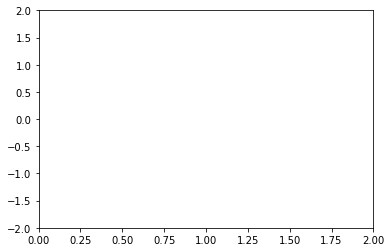

In [23]:
fig = plt.figure()
ax = plt.axes(xlim=(0, 2), ylim=(-2, 2))
line, = ax.plot([], [], lw=2)

# initialization function: plot the background of each frame
def init():
    line.set_data([], [])
    return line,

# animation function.  This is called sequentially
def animate(i):
    x = np.linspace(0, 2, 1000)
    y = np.sin(2 * np.pi * (x - 0.01 * i))
    line.set_data(x, y)
    return line,

# call the animator.  blit=True means only re-draw the parts that have changed.
anim = FuncAnimation(fig, animate, init_func=init,
                               frames=200, interval=20, blit=True)

# save the animation as an mp4.  This requires ffmpeg or mencoder to be
# installed.  The extra_args ensure that the x264 codec is used, so that
# the video can be embedded in html5.  You may need to adjust this for
# your system: for more information, see
# http://matplotlib.sourceforge.net/api/animation_api.html
plt.show()